# Heston Simulation (short)

In this notebook we try to simulate multi-dimensional data generated by Heston model. We simulate 3-dimensional short sequences and store the data as a .npy document.

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/Colab Notebooks/Numerical Experiment"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['One-dimensional Facebook.ipynb',
 'Processed and simulated data',
 'Original data',
 'Network results',
 '.ipynb_checkpoints',
 'GAN_training-multi-dimensional contrived polynomial.ipynb',
 'include',
 'Polynomial simulation-short.ipynb',
 'Training-huge_network.ipynb',
 'Assessment.ipynb',
 'Training.ipynb',
 'Assessment-new',
 'Heston simulation-short.ipynb']

In [3]:
# for model
import scipy.linalg as linalg
import pandas as pd
import numpy as np

# for simulation
import random
import math
import progressbar

# for visualization
from include import *

choice_1 = 'Heston'
choice_2 = 'Heston log'

## Parameters of SDE generation

In [4]:
para={}
#time，presition of generation, presition of observation
para['T'] = 7*15/365
para['INTERVAL_OBS'] = 7/365
para['SUB_ITERS']= 30
para['INTERVAL_GEN'] = para['INTERVAL_OBS']/para['SUB_ITERS']
para['N_OBS']=15
para['INCREMENT']=math.sqrt(para['INTERVAL_GEN'])

#dimension of stochastic vector (St,Zt)
para['DIM_TOT'] = 6
para['DIM_KNOWN'] = 3
para['DIM_UNKNOWN'] = 3


#other parameters
#common parameters
para['r'] = 0.04
para['d'] = 0.015
para['a'] = para['r']-para['d']
para['l1'] = -7
para['l2'] = -6
para['corrmat']=np.array([[1.,0.3,0.2],[0.3,1.,0.4],[0.2,0.4,1]])
para['L']=np.linalg.cholesky(para['corrmat'])

#parameters for each dimension
para['k1'] = 3.0; para['g1'] = 0.1; para['sigma_v1'] = 0.25; para['rho1'] = -0.8
para['b1'] = para['l1']*(1-para['rho1']**2)+para['l2']*para['rho1']-0.5

para['k2'] = 2.7; para['g2'] = 0.11; para['sigma_v2'] = 0.2; para['rho2'] = -0.75
para['b2'] = para['l1']*(1-para['rho2']**2)+para['l2']*para['rho2']-0.5

para['k3'] = 3.3; para['g3'] = 0.09; para['sigma_v3'] = 0.15; para['rho3'] = -0.85
para['b3'] = para['l1']*(1-para['rho3']**2)+para['l2']*para['rho3']-0.5

## Two functions, mu and sigma

In [5]:
#Two functions mu and sigma
def mu(X):
    S1 = X[0]; Y1 = X[3]
    S2 = X[1]; Y2 = X[4]
    S3 = X[2]; Y3 = X[5]
    result=np.array([(para['a'])*S1,(para['a'])*S2,(para['a'])*S3,
                     para['k1']*(para['g1']-Y1),para['k2']*(para['g2']-Y2),para['k3']*(para['g3']-Y3)])
    return result

def sigma(X):
    S1 = X[0]; Y1 = X[3]
    S2 = X[1]; Y2 = X[4]
    S3 = X[2]; Y3 = X[5]
    y1=math.sqrt(max(Y1,0));y2=math.sqrt(max(Y2,0));y3=math.sqrt(max(Y3,0))
    a11=math.sqrt(1-para['rho1']**2)*y1*S1
    a12=para['rho1']*y1*S1
    a14=para['sigma_v1']*y1
    a21=math.sqrt(1-para['rho2']**2)*y2*S2
    a22=para['rho2']*y2*S2
    a24=para['sigma_v2']*y2
    a31=math.sqrt(1-para['rho3']**2)*y3*S3
    a32=para['rho3']*y3*S3
    a34=para['sigma_v3']*y3
    
    result = np.array([[para['L'][0,0]*a11,para['L'][0,0]*a12,para['L'][0,1]*a21,para['L'][0,1]*a22,para['L'][0,2]*a31,para['L'][0,2]*a32],
                       [para['L'][1,0]*a11,para['L'][1,0]*a12,para['L'][1,1]*a21,para['L'][1,1]*a22,para['L'][1,2]*a31,para['L'][1,2]*a32],
                       [para['L'][2,0]*a11,para['L'][2,0]*a12,para['L'][2,1]*a21,para['L'][2,1]*a22,para['L'][2,2]*a31,para['L'][2,2]*a32],
                       [0,para['L'][0,0]*a14,0,para['L'][0,1]*a24,0,para['L'][0,2]*a34],
                       [0,para['L'][1,0]*a14,0,para['L'][2,1]*a24,0,para['L'][1,2]*a34],
                       [0,para['L'][2,0]*a14,0,para['L'][2,1]*a24,0,para['L'][2,2]*a34]])
    return result

## Heston model data generation

In [6]:
#generation parameters
dt = para['INTERVAL_GEN']
dw = para['INCREMENT']
observes = 5000

#data generation
data_obs = np.empty([observes,para['N_OBS'],para['DIM_KNOWN']])
for i in progressbar.progressbar(range(observes)):
    S0=np.random.multivariate_normal(np.array([100,100,100]), 70*para['corrmat'])
    Y0=np.array([0.1,0.1,0.1])
    X0=np.concatenate((S0,Y0),axis=0).reshape(-1)
    X1 = X0; X2 = X0
    for j in range(para['N_OBS']):
        data_obs[i,j] = X2[0:para['DIM_KNOWN']]
        for k in range(para['SUB_ITERS']):
            std_BM_increment = np.random.randn(6,1)
            #calculate mu and sigma
            X2 = X1 + mu(X1)*dt + np.matmul(sigma(X1),std_BM_increment).reshape(-1)*dw
            X1 = X2

100% (5000 of 5000) |####################| Elapsed Time: 0:01:53 Time:  0:01:53


## Visualization of generated data

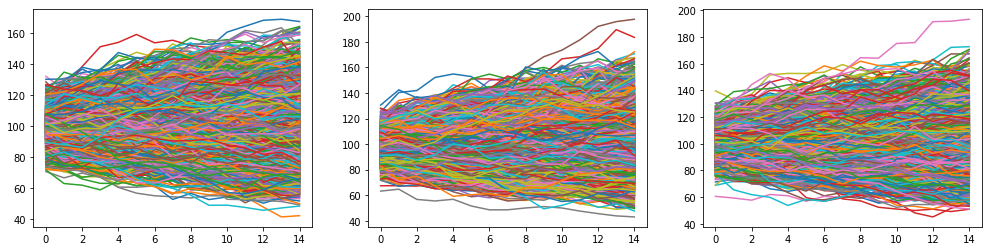

In [7]:
visualize(choice_1,data_obs)

## Transform into log returns

In [8]:
data_obs_return=np.empty([observes,para['N_OBS'],para['DIM_KNOWN']])
for i in range(observes):
    data_obs_return[i,0,:]=np.log(data_obs[i,0,:])
    for j in range(para['N_OBS']-1):
        data_obs_return[i,j+1,:]=np.log(data_obs[i,j+1])-np.log(data_obs[i,j])


## Visualization of log returns

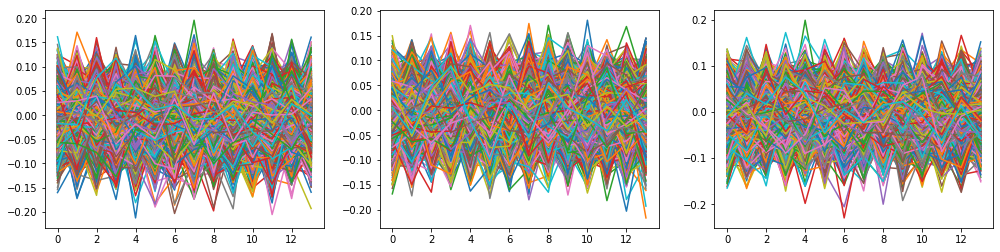

In [9]:
visualize(choice_2, data_obs_return)

## Save generated data

In [10]:
np.save('./Processed and simulated data/data_obs_'+choice_1+'.npy',data_obs)
np.save('./Processed and simulated data/data_obs_'+choice_2+'.npy',data_obs_return)